In [3]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

We are going to solve Damped Harmonic Oscillator problem using Kolmogorov-Arnold Network. Our setting will be the same as in default DHO solution method. As you will see, it differs not that much from FF training (thanks to authors of pykan for their effort in providing KAN as pytorch module).

Our library provides easy-to-use wrapper for pykan library, but you always kan define your own network.

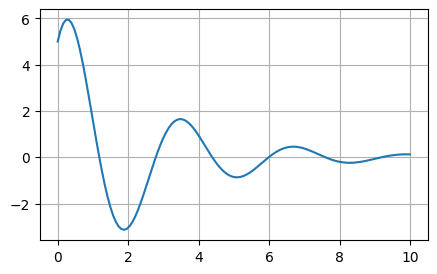

In [5]:
def analytical(t):
    return torch.exp(-0.4*t)*(4.59*torch.sin(1.96*t) + 5*torch.cos(1.96*t))

T = 10              # We need to fix some computational domain.
p = (0.2, 2.0)      # Parameters that yields interesting function.
x0, v0 = 5.0, 7.0   # Initial values may be arbitrary.

t = torch.linspace(0, T, 128)
solution = analytical(t)
fig = plt.figure(figsize=(5, 3))
plt.plot(t, solution)
plt.grid()
plt.show()

In [6]:
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints (training data) sampler must return tuple (points, values).
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad=True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain = {'t': [0, T]}
collocation_sampler = RandomSampler(domain, 256, return_dict=False)

# Test points sampler must return tuple (points, values) of shape [num_pts, coords].
test_points_sampler = ConstantSampler(
    (t.reshape(-1, 1), solution.reshape(-1, 1))
    )

In [27]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

Here is simple version of training:

In [8]:
from pinns import Trainer
from pinns.models import KAN
from pinns.optimizers import Adam

pinn = KAN([1, 5, 1], type = 'efficient', grid_size = 15)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

trainer.train(
    num_iters=100,
    optimizers=[(0, adam)],
    validate_every=1
)

Model has 200 trainable parameters.


  0%|          | 0/100 [00:00<?, ?it/s]

For classic KAN, we can employ grid refining method, as described in pykan: at some point we change number of grid points and continue training of the  same model. Interestingly, this method works not as for classic regression  problems (due to the peculiarities of PINNs training), but as described in  our paper it somewhat helps to decrease approximation error.

Here is how to do it:

In [29]:
# (grid size, how much iters)
gridit = [(5, 250), (20, 250)]

pinn = KAN([1, 5, 1], grid = 5)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

for i, (grid, it) in enumerate(gridit):
    
    pts, _ = test_points_sampler()

    pinn = KAN([1, 5, 1], grid = grid).initialize_from_another_model(trainer.model, pts)
    trainer.model = pinn
        
    adam = Adam(pinn, lr = 1e-2)
    
    # trainer.iter += 1
    trainer.train(
        num_iters = it,
        optimizers=[(0, adam)],
        validate_every=1,
        show_progress=True
    )

Model has 146 trainable parameters.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [30]:
from pinns.errors import l2
trainer.evaluate(l2)

1.5000905652005678

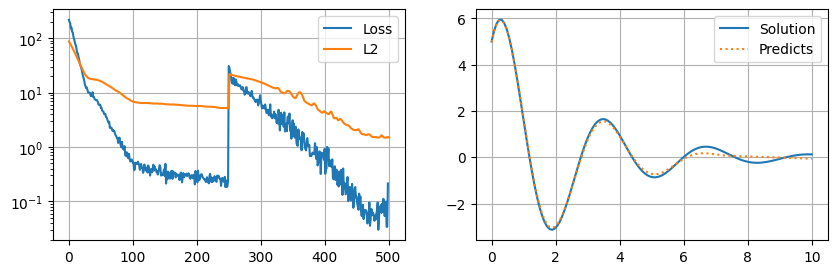

In [31]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(trainer.loss_history, label='Loss')
axs[0].plot(trainer.error_history, label='L2')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(t.reshape(-1, 1))
axs[1].plot(t, solution, label='Solution')
axs[1].plot(t, preds.detach(), label='Predicts', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.show()

And we kan visualize activation functions of our trained network, if we use default pykan version of model.

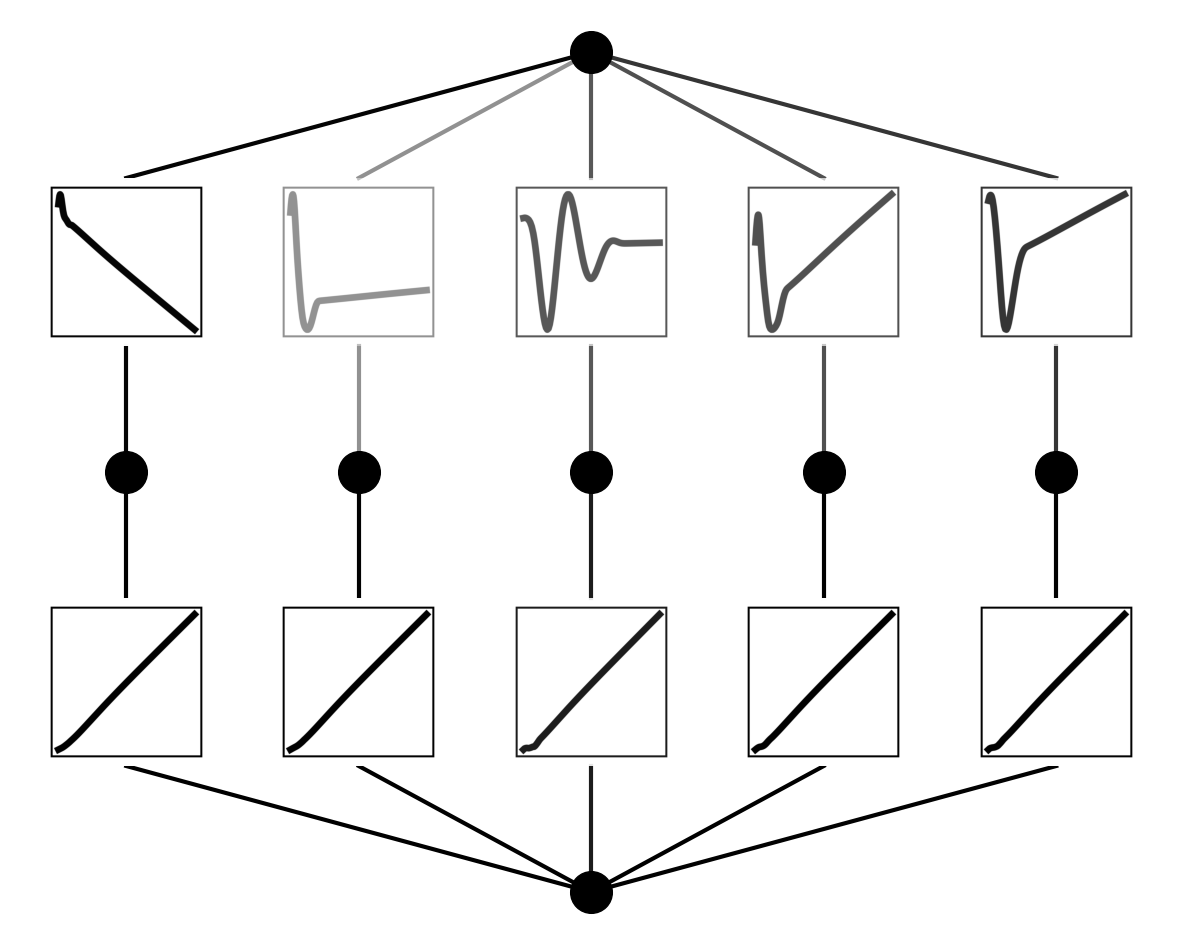

In [32]:
trainer.model.model.plot(scale = 1.5)

In [33]:
pinn.model.auto_symbolic()

fixing (0,0,0) with sigmoid, r2=0.9997727274894714
fixing (0,0,1) with sigmoid, r2=0.9997512102127075
fixing (0,0,2) with abs, r2=0.9995760321617126
fixing (0,0,3) with abs, r2=0.9996871948242188
fixing (0,0,4) with abs, r2=0.9996704459190369
fixing (1,0,0) with arcsin, r2=0.9966241121292114
fixing (1,1,0) with gaussian, r2=0.888985812664032
fixing (1,2,0) with gaussian, r2=0.5961562395095825
fixing (1,3,0) with gaussian, r2=0.7494540810585022
fixing (1,4,0) with gaussian, r2=0.7733782529830933


In [34]:
pinn.model.symbolic_formula()[0][0]

-1.77*asin(4.25*sigmoid(0.17*x_1 - 0.8) - 2.31) + 0.65 + 1.98*exp(-5763.3*(sigmoid(0.8 - 0.17*x_1) - 0.68)**2) - 0.81*exp(-0.63*(1 - 0.04*Abs(9.69*x_1 - 2.02))**2) - 1.86*exp(-4.34*(1 - 0.08*Abs(8.8*x_1 - 2.28))**2) - 2.51*exp(-10.8*(1 - 0.07*Abs(8.2*x_1 - 2.73))**2)

However, this analytical formula is a little bit complicated. Here is exact solution:

$$e^{-0.4t}(4.59 \sin(1.96t) + 5 \cos(1.96t))$$

Let's see predictions of model with fixed activation functions.

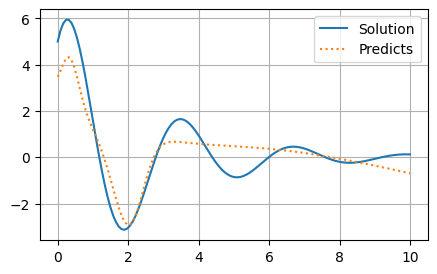

In [35]:
fig = plt.figure(figsize=(5, 3))

preds = pinn.predict(t.reshape(-1, 1))
plt.plot(t, solution, label='Solution')
plt.plot(t, preds.detach(), label='Predicts', linestyle=':')
plt.grid()
plt.legend()

plt.show()

As we can see, symbolic representation is broken (and also $R^2$ of some activation functions is pretty low). This happened due to one of two reasons (or both):

1. There are not enough functions in symbolic library to search from. Maybe we should expand it.
2. Model itself is not designed well enough: maybe if we increase the width of layer, or change some hyperparameters such as domain of activation functions, we will see better behavior.

There is pretty much room for experimenting. Hope that our interpretation library will perform better.